# Building a benchmarking tool for e-commerce

In this notebook we constructed a CNN model for image classification and Random Forest Regression for prediction of sales in the context of e-commerce for seasonality trends such as Halloween.

# Setting up the environment: Downloading and installing libraries

In [ ]:
pip install beautifulsoup4 requests

In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download dataset for training

Web scraping can be a risky tecnquiques, becuse many websites are protected and many images online are protected by the copyright. For this reason we decided to web scrape only from two websites: Vecteezy and Pexel, that offer free from copyright images.

### Web scrape and download images from Vecteezy

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin

# Base URL of the page containing the images
base_url = "https://www.vecteezy.com/free-photos/witch?page="

# Specify the directory to save the downloaded images
save_directory = r'C:\Users\Josue\Escritorio\test images'
os.makedirs(save_directory, exist_ok=True)

# Loop through pages 1 to 10
for page_num in range(2, 11):
    # Build the URL for the current page
    page_url = base_url + str(page_num)

    # Send a GET request to the page
    response = requests.get(page_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all <a> tags with the specified class
        image_links = soup.find_all('a', class_='ez-resource-thumb__link')

        # Loop through each <a> tag and download the associated image
        for link in image_links:
            # Get the image URL from the <img> tag inside the <a> tag
            image_url = link.find('img')['src']

            # Create an absolute URL if it's a relative URL
            if not urlparse(image_url).scheme:
                image_url = urljoin(page_url, image_url)

            # Get the image filename from the URL
            img_filename = os.path.join(save_directory, os.path.basename(image_url))

            # Download the image
            response = requests.get(image_url)
            if response.status_code == 200:
                with open(img_filename, 'wb') as file:
                    file.write(response.content)
                print(f"Image downloaded: {img_filename}")
            else:
                print(f"Failed to download image from {image_url}")
    else:
        print(f"Failed to retrieve the page {page_url}. Status Code: {response.status_code}")


## Web scrape and download images from Pexel


This website offers images free from copyright to use. However, to webscrape images it is needed a secific API. After registering on the website we proceeded downloading 50 images for each category of interest: cats, ghosts, skeletons, clowns, witches and pumpkins. The images are then stored into folders with the name of the category.


In [ ]:
import pandas as pd # creating the table
from urllib.parse import urljoin
from time import sleep
from selenium import webdriver
import time

In [ ]:
import requests
import os
from urllib.parse import urlparse

# The api_key is personal and comes from registration on the website
# api_key = 'yEymjCYJhzak2K3vJG7IdaYsicPNTwlz6VtGLCpq6VdNheGGkq4y08zc'

# Pexels API endpoint for searching photos
api_url = 'https://api.pexels.com/v1/search'

# Set up the headers with the API key
headers = {'Authorization': api_key}

# Specify the search query
search_query = 'scary clown'

# Specify the folder name where to save the images
folder_name = 'clown'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Specify the number of photos to download
photos_to_download = 50

# Make a request to the Pexels API for clown photos
params = {'query': search_query, 'per_page': photos_to_download}
response = requests.get(api_url, headers=headers, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Extract image URLs and download the images
    for photo in data['photos']:
        image_url = photo['src']['original']

        # Extract the image file name from the URL
        image_name = os.path.basename(urlparse(image_url).path)

        # Create the full path for saving the image in the specified folder
        image_path = os.path.join(folder_name, image_name)

        # Make a request to the image URL
        image_response = requests.get(image_url)

        # Check if the request was successful
        if image_response.status_code == 200:
            # Save the image to the specified folder
            with open(image_path, 'wb') as image_file:
                image_file.write(image_response.content)
            print(f"Downloaded: {image_path}")
        else:
            print(f"Failed to download: {image_url}")
else:
    print(f"Error: {response.status_code} - {response.text}")


After the automated process of web scrapig the has been a manual process of data cleaning, in order to offer the model the most representative images to learn from.

### Colors reduction with K-means algorithm

The main idea is that, since the data scraped from Pexels are really detailed, high resolution, the best way to process the images is to reduce their dimentions. When prossessing images a good practice is reduce the colors present in the pucture. Usually the CNN does it already, however we wanted to simplify even more.
We decided to implement a k-means method in order to achieve our goal.
The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. The "cluster center" is the arithmetic mean of all the points belonging to the cluster and each point is closer to its own cluster center than to other cluster centers.

We set the number of colors to 10, certaintly some details are lost but the resulting images are still useful for the identification of the object.

In [ ]:
from sklearn.cluster import KMeans
from skimage import io
import os
import numpy as np

# Set the path to the folder
image_folder = '/Users/francesconardin/Documents/università/magistrale/corsi magistrale/secondo anno/big project/dataset_cnn/witch'

# Set the number of colors equal to 10
n_colors = 10

# Set a new folder to save the processed images
output_folder = '/Users/francesconardin/Documents/università/magistrale/corsi magistrale/secondo anno/big project/dataset_cnn/witch_reduced'
os.makedirs(output_folder, exist_ok=True)

# Iterate through each image in the input folder
for filename in os.listdir(image_folder):
    if filename.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(image_folder, filename)

        # Read the image
        img = io.imread(img_path)

        # Reshape the image data to (num_pixels, num_channels)
        flattened_img = img.reshape((-1, img.shape[2]))

        # Apply k-Means clustering
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(flattened_img)

        # Get the cluster centers (representative colors)
        colors = kmeans.cluster_centers_.astype(int)

        # Replace each pixel with its nearest representative color
        quantized_img = colors[kmeans.labels_].reshape(img.shape)

        # Convert image data to uint8 before saving
        quantized_img = quantized_img.astype(np.uint8)

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, f'quantized_{filename}')
        io.imsave(output_path, quantized_img)

        print(f"Processed: {filename} -> Saved as: {output_path}")


## Web scraping from Etsy
To test the CNN and train the Random Forest Regression for predicting sales

In [ ]:
pip install requests soupsieve lxml

In [ ]:
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
import requests

In [ ]:
import requests

# Make a simple request to a website
response = requests.get("https://httpbin.org/user-agent")

# Extract the User-Agent from the response headers
user_agent = response.json()['user-agent']

print(f"Your User-Agent: {user_agent}")


In [ ]:
def get_etsy_search_links(queries):
    base_url = "https://www.etsy.com/search?q="
    search_links = []

    price_ranges = [("&max=20", "below_20"), ("&min=20&max=50", "20_50"), ("&min=50&max=100", "50_100"), ("&min=100", "100")]

    for query in queries:
        formatted_query = query.replace(" ", "+")
        for price_range, price_bucket in price_ranges:
            full_url = f"{base_url}{formatted_query}&explicit=1&ship_to=FR&price_bucket=1{price_range}&ref=search_bar"
            search_links.append(full_url)

    return search_links

# Example usage:
search_queries = [
    "halloween shirt",
    "halloween costume",
    "halloween dress",
    "halloween leggings",
    "halloween sweater",
    "halloween hoodie",
    "halloween socks",
    "halloween skirt",
    "halloween pants",
    "halloween hat",
    "halloween jacket",
    "halloween scarf",
    "halloween gloves",
    "halloween mask",
    "halloween shoes",
    "halloween tie",
    "halloween cape",
    "halloween onesie",
    "halloween outfit"
]

etsy_links = get_etsy_search_links(search_queries)
for link in etsy_links:
    print(link)


In [ ]:
from bs4 import BeautifulSoup
import requests

def get_etsy_soup(url):
    headers = {
        'User-Agent': 'python-requests/2.31.0'
    }
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def save_soup_to_file(soup, query, price_range):
    file_name = f"{query.replace(' ', '_')}_{price_range}.txt"
    with open(file_name, "w", encoding="utf-8") as file:
        file.write(str(soup))

def get_etsy_search_links(queries):
    base_url = "https://www.etsy.com/search?q="
    search_links = []
    price_ranges = [("&max=20", "0-20"), ("&min=20&max=50", "20-50"), ("&min=50&max=100", "50-100"), ("&min=100", "100+")]

    for query in queries:
        formatted_query = query.replace(" ", "+")
        for price_range, label in price_ranges:
            full_url = f"{base_url}{formatted_query}&ref=search_bar&explicit=1&ship_to=FR&price_bucket=1{price_range}"
            search_links.append((query, full_url, label))  # Store query, link, and label in tuple

    return search_links


search_queries = [
    "halloween shirt",
    "halloween costume",
    "halloween dress",
    "halloween leggings",
    "halloween sweater",
    "halloween hoodie",
    "halloween socks",
    "halloween skirt",
    "halloween pants",
    "halloween hat",
    "halloween jacket",
    "halloween scarf",
    "halloween gloves",
    "halloween mask",
    "halloween shoes",
    "halloween tie",
    "halloween cape",
    "halloween onesie",
    "halloween outfit"
]

etsy_links = get_etsy_search_links(search_queries)

for query, link, price_range in etsy_links:
    soup = get_etsy_soup(link)
    save_soup_to_file(soup, query, price_range)


In [ ]:
#Working - Moves to soups folder
import os
import shutil

# Current directory
current_directory = os.getcwd()

# Directory to move text files
destination_directory = os.path.join(current_directory, "soups")

# Ensure the destination directory exists, if not create it
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# List all files in the current directory
files = os.listdir(current_directory)

# Filter text files that start with "halloween"
halloween_files = [file for file in files if file.lower().startswith("halloween") and file.lower().endswith(".txt")]

# Move identified files to the "soups" directory
for file_name in halloween_files:
    source_path = os.path.join(current_directory, file_name)
    destination_path = os.path.join(destination_directory, file_name)
    shutil.move(source_path, destination_path)
    print(f"Moved {file_name} to soups folder.")


In [ ]:
#Saving with description name truncated to 40 characters and avoiding conflicting characters to save the images. Gives the same # as the last character
#to images that are repeated on each folder.
import os
import requests
from bs4 import BeautifulSoup
import urllib.request
import re

# Function to extract image links and alt descriptions from HTML content
def extract_image_data(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    image_tags = soup.find_all('img')  # Find all img tags
    image_data = []
    for img in image_tags:
        img_src = img.get('src')
        img_alt = img.get('alt')
        if img_src and img_alt:
            img_data = {'src': img_src, 'alt': img_alt}
            image_data.append(img_data)
    return image_data

# Directory path containing the .txt files
directory_path = r"C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups"
output_directory = r"C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\images"

for file_name in os.listdir(directory_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()
            image_data = extract_image_data(html_content)

            # Create a folder with the same name as the .txt file (without extension)
            folder_name = os.path.splitext(file_name)[0]
            folder_path = os.path.join(output_directory, folder_name)
            os.makedirs(folder_path, exist_ok=True)

            # Download images to the created folder with truncated alt description as file name
            for idx, img_info in enumerate(image_data):
                img_src = img_info['src']
                img_alt = img_info['alt'][:40].replace('\\', '_').replace('/', '_')  # Truncate to 40 characters and replace backslash and slash with underscore
                img_extension = img_src.split('.')[-1]
                img_name = re.sub(r'[^\w\s]', '', img_alt)[:40] + f"_{idx + 1}.{img_extension}"
                img_path = os.path.join(folder_path, img_name)
                try:
                    urllib.request.urlretrieve(img_src, img_path)
                except Exception as e:
                    print(f"Failed to download image {img_src}: {e}")


In [ ]:
import os
import pandas as pd
import re

directory_path = r"C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\clean stars"

descriptions = []
prices = []
review_numbers = []
file_names = []

for file_name in os.listdir(directory_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()
            description = ""
            price = ""
            review_number = ""
            for line in lines:
                if line.startswith('----------------------------------------'):
                    if description != "":
                        descriptions.append(description.strip())
                        prices.append(price)
                        review_numbers.append(review_number)
                        file_names.append(file_name)

                    description = ""
                    price = ""
                    review_number = ""
                elif re.match(r'\$\d+(?:\.\d+)?', line):
                    price = line.strip()
                elif re.search(r'\(\d[\d,]*\)', line):
                    review_number = re.search(r'\(\d[\d,]*\)', line).group()
                else:
                    description += line.strip() + " "

            if description != "":
                descriptions.append(description.strip())
                prices.append(price)
                review_numbers.append(review_number)
                file_names.append(file_name)


# Convert into a data frame
data = {'Description': descriptions, 'Price': prices, 'Review_Number': review_numbers, 'File_Name': file_names}
df = pd.DataFrame(data)
# Reset index
df.reset_index(drop=True, inplace=True)

df

In [ ]:

from bs4 import BeautifulSoup
import os
import re
import urllib.request


def extract_image_data(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    image_tags = soup.find_all('img')  # Find all img tags
    image_data = []
    for img in image_tags:
        img_src = img.get('src')
        img_alt = img.get('alt')
        if img_src and img_alt:
            img_data = {'src': img_src, 'alt': img_alt}
            image_data.append(img_data)
    return image_data

#Set the directory and output paths accordingly
directory_path = r"C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups"
output_directory = r"C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\images"

for file_name in os.listdir(directory_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()
             # Extract image data
            image_data = extract_image_data(html_content)

            # Create a folder with the same name as the .txt file (without extension)
            folder_name = os.path.splitext(file_name)[0]
            folder_path = os.path.join(output_directory, folder_name)
            os.makedirs(folder_path, exist_ok=True)

            # Download images to the created folder with truncated alt description as file name
            for idx, img_info in enumerate(image_data):
                img_src = img_info['src']
                img_alt = img_info['alt'][:40].replace('\\', '_').replace('/', '_')  # Truncate to 40 characters and replace backslash and slash with underscore
                img_extension = img_src.split('.')[-1]
                img_name = re.sub(r'[^\w\s]', '', img_alt)[:40] + f"_{idx + 1}.{img_extension}"
                img_path = os.path.join(folder_path, img_name)
                try:
                    urllib.request.urlretrieve(img_src, img_path)
                except Exception as e:
                    print(f"Failed to download image {img_src}: {e}")

soup = BeautifulSoup(html_content, "html.parser")
target_classes = ['wt-text-caption', 'wt-text-gray', 'wt-display-inline-block', 'wt-nudge-l-3', 'wt-pr-xs-1']
# Target classes to get ratings
rating = ['wt-display-inline-block', 'wt-nudge-b-1', 'set-review-stars-line-height-to-zero']

# Custom filtering function to check if an element has all specified classes FOR NUMBER OF REVIEWS
def has_target_classes(tag):
    return all(class_ in tag.get('class', []) for class_ in target_classes)

# Custom filtering function to check if an element has all specified classes FOR RATING OF PRODUCTS
def has_target_classes_rating(tag):
    return all(class_ in tag.get('class', []) for class_ in rating)

#Find number of reviews
filtered_elements = soup.find_all(has_target_classes)
#Find number of ratings
rating_elements = soup.find_all(has_target_classes_rating)
# rating_elements
parentheses_text = []

# Store the product ratings
ratings = []

for element in filtered_elements:
    text = element.get_text()
    matches = re.findall(r'\((.*?)\)', text)
    for match in matches:
      try:
        number = int(match.replace(',', '')) # Convert to integer and remove commas
        parentheses_text.append(number)
      except ValueError:
        pass # Ignore if conversion to integer fails

for element in rating_elements:
    rating_input = element.find_next('input', attrs={'type': 'hidden', 'name': 'rating'})
    if rating_input and 'value' in rating_input.attrs:
        rating = float(rating_input['value'])
        ratings.append(rating)

# Find price elements
price_elements = soup.find_all(class_='lc-price')

# Extract and store the prices
prices = []
for element in price_elements:
  if not element.find(class_='wt-text-strikethrough'):
    price_text = element.find(class_='currency-value').get_text().replace(',', '')  # Remove commas
    try:
        price = float(price_text)
        prices.append(price)
    except ValueError:
        pass  # Ignore if conversion to float fails



In [ ]:
df = df[df['Review_Number'].str.strip() != '']
df = df.reset_index(drop=True)

df

In [ ]:
df['Price'] = df['Price'].str.replace('$', '')
df

In [ ]:
df['Review_Number'] = df['Review_Number'].str.replace(r'[\(\)]', '')
df

In [ ]:
df['File_Name'] = df['File_Name'].str.replace('halloween_', '').str.replace('_clean.txt', '')
df

In [ ]:
split_data = df['File_Name'].str.split('_', n=1, expand=True)
df['Product type'] = split_data[0]
df['Price Range'] = split_data[1]
df['File_Name'] = 'halloween_' + df['File_Name'] + '_clean.txt'
df

In [ ]:
import os

main_folder_path = r'C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\images'

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    description_name = row['Description']
    truncated_description = description_name.replace('\\', '_').replace('/', '_')  # Replace backslashes and slashes

    # Check if the description name length is at least 20 characters
    if len(truncated_description) >= 20:
        # Generate a sliding window of 20 characters through the description name
        for i in range(len(truncated_description) - 19):
            window = truncated_description[i:i+20]  # Take 20 characters at a time

            # Iterate through each subfolder in the main folder
            for folder_name in os.listdir(main_folder_path):
                folder_path = os.path.join(main_folder_path, folder_name)

                # Check if the folder exists and contains matching files
                if os.path.isdir(folder_path):
                    matching_files = [file for file in os.listdir(folder_path) if window in file]

                    if matching_files:
                        image_file_name = os.path.join(folder_path, matching_files[0])
                        df.at[index, 'Image_File'] = image_file_name  # Store the matched image file name/path in the DataFrame
                        break  # Stop searching other folders once a match is found
            if 'Image_File' in df.columns:
                break  # Break the loop if a match is found



In [ ]:
# Download into an excel file
df.to_excel('output.xlsx', index=False)

In [ ]:
pip install imagehash

In [ ]:
import os
from PIL import Image
import imagehash
import shutil

def find_duplicates(directory):
    hash_dict = {}
    duplicates = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if os.path.isfile(file_path):
                with Image.open(file_path) as img:
                    img_hash = imagehash.average_hash(img)
                    if img_hash in hash_dict:
                        duplicates.append(file_path)
                    else:
                        hash_dict[img_hash] = file_path

    return duplicates

def remove_duplicates(duplicate_list):
    for duplicate in duplicate_list:
        os.remove(duplicate)

#Set the directory and output paths accordingly

source_folder = r'C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\images'
output_folder = r'C:\Users\57300\OneDrive - Universidad Externado de Colombia\Desktop\M2\Machine learning & Statistical Learning\soups\selected unique images'

# Find duplicates across all folders
all_duplicates = find_duplicates(source_folder)

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Move unique images to folders with original folder names
for duplicate in all_duplicates:
    folder_name = os.path.basename(os.path.dirname(duplicate))
    target_folder = os.path.join(output_folder, folder_name)
    os.makedirs(target_folder, exist_ok=True)
    shutil.move(duplicate, target_folder)


# Data augmentation

After web scraping from different websites and reducing the complex images from Pexels and other websites such as Vecteezy, we decided to use data augmentation tecniques to increment the size of our training set. In this way, even if the original dataset scraped from the internet was not of big dimentions the resulting training set is big enough to train our CNN.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import imghdr

# Specify the path to the folder containing original images
original_images_folder = '/Users/francesconardin/Documents/università/magistrale/corsi magistrale/secondo anno/big project/dataset_cnn/witch_reduced'

# Specify the path to the folder where augmented images will be saved
output_folder = '/Users/francesconardin/Documents/università/magistrale/corsi magistrale/secondo anno/big project/dataset_cnn/witch_reduced_augmeted'
os.makedirs(output_folder, exist_ok=True)

# Create an ImageDataGenerator for the first set of augmentations (rotation and flips)
datagen_rotation_flip = ImageDataGenerator(
    rotation_range=45,        # Rotation
    horizontal_flip=True,     # Mirroring
    vertical_flip=True,       # Mirroring
    fill_mode='nearest'       # Fill mode for new pixels created by rotations
)

# Create an ImageDataGenerator for the second set of augmentations (rotation, flips, and zoom)
datagen_rotation_flip_zoom = ImageDataGenerator(
    rotation_range=45,        # Rotation
    horizontal_flip=True,     # Mirroring
    vertical_flip=True,       # Mirroring
    zoom_range=[0.8, 1.2],    # Zoom in and out
    fill_mode='nearest'       # Fill mode for new pixels created by rotations
)

# Iterate through each image in the original folder
for image_name in os.listdir(original_images_folder):
    image_path = os.path.join(original_images_folder, image_name)

    try:
        # Check if the file is an image before attempting to load
        if imghdr.what(image_path) is not None:
            # Load an example image
            img = image.load_img(image_path)
            print(f"Loaded image: {image_name}")

            # Convert the image to a NumPy array
            x = image.img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Generate augmented images with the first set of augmentations and save them
            i = 0
            for batch in datagen_rotation_flip.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix=f'aug1_{image_name.split(".")[0]}', save_format='jpeg'):
                i += 1
                if i > 7:  # Generate 7 augmented images for the first set of augmentations
                    break

            # Generate augmented images with the second set of augmentations and save them
            i = 0
            for batch in datagen_rotation_flip_zoom.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix=f'aug2_{image_name.split(".")[0]}', save_format='jpeg'):
                i += 1
                if i > 7:  # Generate 7 augmented images for the second set of augmentations
                    break

            print(f"Processed: {image_name} -> Saved in: {output_folder}")

    except Exception as e:
        print(f"Error processing {image_name}: {e}")


For simplicity, given the size of the data set, everything is stored in this folder in Google Drive: https://drive.google.com/drive/folders/1VI-QJf_S5cmJa3vZlxjxxGziaJSkEK4i?usp=sharing

# Train the model

Testing different architectures to find the best performing one

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
new_directory_path = '/content/drive/MyDrive/training images'

## Traditional architecture composed of several layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dropout


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
# First layer
model.add(Conv2D(200, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(BatchNormalization())
# Second layer
model.add(Conv2D(180, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(5,5))
# Third layer
model.add(Conv2D(180, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Fourth layer
model.add(Conv2D(140, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Fifth layer
model.add(Conv2D(100, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Sixth layer
model.add(Conv2D(50, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(5,5))
# Fully connected layer
model.add(Flatten())
model.add(Dense(180, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))

# Final layer for classificate 6 classes
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode = "rgb",
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode = "rgb",
    class_mode='categorical',
    subset='validation'
)

# Fitting the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])



Found 366 images belonging to 6 classes.
Found 89 images belonging to 6 classes.
Epoch 1/50
12/12 [==============================] - 160s 12s/step - loss: 2.4825 - accuracy: 0.1803 - val_loss: 1.9267 - val_accuracy: 0.1461
Epoch 2/50
12/12 [==============================] - 5s 380ms/step - loss: 2.2743 - accuracy: 0.2077 - val_loss: 2.5213 - val_accuracy: 0.1124
Epoch 3/50
12/12 [==============================] - 5s 390ms/step - loss: 2.0649 - accuracy: 0.2295 - val_loss: 3.7202 - val_accuracy: 0.1236
Epoch 4/50
12/12 [==============================] - 5s 367ms/step - loss: 1.9761 - accuracy: 0.2322 - val_loss: 3.9067 - val_accuracy: 0.1236
Epoch 5/50
12/12 [==============================] - 5s 385ms/step - loss: 1.8637 - accuracy: 0.3115 - val_loss: 5.4881 - val_accuracy: 0.1236
Epoch 6/50
12/12 [==============================] - 5s 379ms/step - loss: 1.9058 - accuracy: 0.2787 - val_loss: 5.3855 - val_accuracy: 0.1236


## ResNet-18 architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# Define the identity block for ResNet-18

def identity_block(x, filters, dropout_rate=0.2):
    f1, f2, f3 = filters

    x_shortcut = x
    droput_rate=0.2

    x = Conv2D(f1, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)  # Add dropout after the first convolution

    x = Conv2D(f2, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)  # Add dropout after the second convolution

    x = Conv2D(f3, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut connection
    x_shortcut = Conv2D(f3, kernel_size=(1, 1), padding='same', activation='relu')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = tf.keras.layers.Activation('relu')(x)

    return x


# Build ResNet-18 model
input_shape = (150, 150, 3)
input_tensor = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

x = identity_block(x, [64, 64, 64])
x = identity_block(x, [64, 64, 64])

x = identity_block(x, [128, 128, 128])
x = identity_block(x, [128, 128, 128])

x = identity_block(x, [256, 256, 256])
x = identity_block(x, [256, 256, 256])

x = identity_block(x, [512, 512, 512])
x = identity_block(x, [512, 512, 512])

x = AveragePooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation'
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])


Found 228 images belonging to 6 classes.
Found 53 images belonging to 6 classes.
Epoch 1/50
8/8 [==============================] - 29s 897ms/step - loss: 2.3831 - accuracy: 0.1711 - val_loss: 1.7664 - val_accuracy: 0.1887
Epoch 2/50
8/8 [==============================] - 5s 579ms/step - loss: 2.3165 - accuracy: 0.2105 - val_loss: 1.7690 - val_accuracy: 0.1887
Epoch 3/50
8/8 [==============================] - 5s 577ms/step - loss: 2.3146 - accuracy: 0.2325 - val_loss: 1.7678 - val_accuracy: 0.2453
Epoch 4/50
8/8 [==============================] - 5s 580ms/step - loss: 2.1578 - accuracy: 0.2325 - val_loss: 1.7678 - val_accuracy: 0.1887
Epoch 5/50
8/8 [==============================] - 5s 605ms/step - loss: 2.1681 - accuracy: 0.2061 - val_loss: 1.7671 - val_accuracy: 0.2453
Epoch 6/50
8/8 [==============================] - 5s 684ms/step - loss: 2.0631 - accuracy: 0.2544 - val_loss: 1.7770 - val_accuracy: 0.2453


## DenseNet architecture


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage import exposure
import numpy as np

# Dense block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        # Batch normalization and ReLU
        x = BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        # 3x3 Convolution
        x = Conv2D(growth_rate, (3, 3), padding='same')(x)

    return x

# Transition block
def transition_block(x):
    # Batch normalization and ReLU
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 1x1 Convolution and average pooling
    x = Conv2D(int(x.shape[-1] * 0.5), (1, 1), padding='same')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x

# Build DenseNet model
input_shape = (150, 150, 3)  # Use 3 channels for full color images
input_tensor = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Dense blocks with transition blocks in between
num_layers = 4
growth_rate = 32

for _ in range(3):  # Add more dense blocks
    x = dense_block(x, num_layers, growth_rate)
    x = transition_block(x)

x = AveragePooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=contrast_stretching
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])


Found 366 images belonging to 6 classes.
Found 89 images belonging to 6 classes.
Epoch 1/50
12/12 [==============================] - 18s 455ms/step - loss: 2.1862 - accuracy: 0.2459 - val_loss: 1.7801 - val_accuracy: 0.2360
Epoch 2/50
12/12 [==============================] - 5s 432ms/step - loss: 2.1160 - accuracy: 0.2077 - val_loss: 1.7704 - val_accuracy: 0.2360
Epoch 3/50
12/12 [==============================] - 5s 375ms/step - loss: 2.0015 - accuracy: 0.2104 - val_loss: 1.7623 - val_accuracy: 0.2360
Epoch 4/50
12/12 [==============================] - 4s 366ms/step - loss: 2.0380 - accuracy: 0.2322 - val_loss: 1.7596 - val_accuracy: 0.2360
Epoch 5/50
12/12 [==============================] - 5s 382ms/step - loss: 1.9630 - accuracy: 0.2432 - val_loss: 1.7592 - val_accuracy: 0.2360
Epoch 6/50
12/12 [==============================] - 5s 389ms/step - loss: 1.9441 - accuracy: 0.2295 - val_loss: 1.7544 - val_accuracy: 0.2360
Epoch 7/50
12/12 [==============================] - 4s 328ms/step 

## GoogLeNet architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from skimage import exposure
import numpy as np

# Creating the inception modules
def inception_module(x, filters):
    f1, f3_reduce, f3, f5_reduce, f5, f_pool = filters

    # 1x1 convolution
    conv1x1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution
    conv3x3_reduce = Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 1x1 convolution followed by 5x5 convolution
    conv5x5_reduce = Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # 3x3 max pooling followed by 1x1 convolution
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_conv = Conv2D(f_pool, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate all branches
    inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_conv])

    return inception_block

# Build modified GoogLeNet model
input_shape = (150, 150, 3)
input_tensor = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Replace identity blocks with inception modules
x = inception_module(x, [64, 64, 128, 16, 32, 32])
x = inception_module(x, [128, 128, 192, 32, 96, 64])


x = AveragePooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Reduced units to 256
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)  # Reduced units to 128
x = Dropout(0.5)(x) # Randomly dropping layers
output = Dense(6, activation='softmax')(x)


model = tf.keras.models.Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=170,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.5,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=128,
    color_mode="rgb",
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=128,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation'
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])


Found 408 images belonging to 6 classes.
Found 100 images belonging to 6 classes.
Epoch 1/50
4/4 [==============================] - 128s 23s/step - loss: 2.3132 - accuracy: 0.1912 - val_loss: 5.7403 - val_accuracy: 0.0800
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 1.9920 - accuracy: 0.2328 - val_loss: 3.5478 - val_accuracy: 0.2200
Epoch 3/50
4/4 [==============================] - 5s 1s/step - loss: 1.7993 - accuracy: 0.2745 - val_loss: 3.2871 - val_accuracy: 0.2100
Epoch 4/50
4/4 [==============================] - 6s 1s/step - loss: 1.7301 - accuracy: 0.3088 - val_loss: 2.4573 - val_accuracy: 0.2200
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 1.6196 - accuracy: 0.3676 - val_loss: 1.9291 - val_accuracy: 0.2500
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 1.6074 - accuracy: 0.3652 - val_loss: 1.7196 - val_accuracy: 0.2600
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 1.5918 - accuracy: 0.355

## Ensamble models using bagging

Use bagging to train different instances of the model by shuffling the training data and combining predictions to see if the prediction improves.

### Traditional architecture

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Number of estimators
n_estimators = 2
# Proportion of samples to use to train each model
max_samples = 0.8

# Create the base CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(200, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(180, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(5, 5))
    model.add(Conv2D(180, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(140, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(100, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(50, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(5, 5))
    model.add(Flatten())
    model.add(Dense(180, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))
    return model

# Compile the base model
base_model = create_model()
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=contrast_stretching,
)

# Initialize histories list to store training history for each model
histories = []

# Train each model in the ensemble
for i in range(n_estimators):
    print(f"Training model {i+1}/{n_estimators}")

    # Shuffle the entire dataset
    indices = np.arange(len(df))
    np.random.shuffle(indices)

    # Split the dataset into training and validation sets
    train_idx = indices[:int(max_samples * len(indices))]  # 80% for training
    val_idx = indices[int(max_samples * len(indices)):]    # 20% for validation

    # Create separate generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df.iloc[train_idx],
        x_col="filename",
        y_col="category",
        target_size=(150, 150),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True,
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=df.iloc[val_idx],
        x_col="filename",
        y_col="category",
        target_size=(150, 150),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
    )

    # Clone the base model for each iteration
    model = create_model()
    model.set_weights(base_model.get_weights())  # Copy weights from the base model

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    # Train the model and store the training history
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])
    histories.append(history)

# Aggregate predictions from all models
ensemble_predictions = []

for history in histories:
    # Use the last trained model from each training history
    model = create_model()
    model.set_weights(history.model.get_weights())  # Copy weights from the trained model

    # Make predictions for the validation set
    ensemble_predictions.append(model.predict(validation_generator))

# Convert the list of predictions into a numpy array
ensemble_predictions = np.array(ensemble_predictions)

# Sum up the predictions from all models
final_predictions = ensemble_predictions.sum(axis=0)

# Get the predicted labels
pred_labels_ensemble = final_predictions.argmax(axis=1)

# Evaluate ensemble accuracy
ensemble_accuracy = accuracy_score(validation_generator.classes, pred_labels_ensemble)
print("Ensemble Accuracy: {:.2f}%".format(ensemble_accuracy * 100))



Training model 1/2
Found 364 validated image filenames belonging to 6 classes.
Found 91 validated image filenames belonging to 6 classes.
Epoch 1/30
6/6 [==============================] - 50s 8s/step - loss: 2.5020 - accuracy: 0.1841 - val_loss: 1.7910 - val_accuracy: 0.3187
Epoch 2/30
6/6 [==============================] - 7s 1s/step - loss: 2.1242 - accuracy: 0.2253 - val_loss: 1.7898 - val_accuracy: 0.2088
Epoch 3/30
6/6 [==============================] - 8s 1s/step - loss: 2.1751 - accuracy: 0.2115 - val_loss: 1.7859 - val_accuracy: 0.2088
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 2.2222 - accuracy: 0.1758 - val_loss: 1.7831 - val_accuracy: 0.2088
Epoch 5/30
6/6 [==============================] - 6s 978ms/step - loss: 2.0313 - accuracy: 0.2253 - val_loss: 1.7781 - val_accuracy: 0.2088
Epoch 6/30
6/6 [==============================] - 7s 1s/step - loss: 1.9157 - accuracy: 0.2445 - val_loss: 1.7428 - val_accuracy: 0.2088
Epoch 7/30
6/6 [====================

### Ensemble of Googlenet models with bagging

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from skimage import exposure
import numpy as np

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Number of estimators
n_estimators = 10
# Proportion of samples to use to train each model
max_samples = 0.8

# Create the base CNN model
def create_model():
  def inception_module(x, filters):
      f1, f3_reduce, f3, f5_reduce, f5, f_pool = filters

      # 1x1 convolution
      conv1x1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

      # 1x1 convolution followed by 3x3 convolution
      conv3x3_reduce = Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
      conv3x3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

      # 1x1 convolution followed by 5x5 convolution
      conv5x5_reduce = Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
      conv5x5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

      # 3x3 max pooling followed by 1x1 convolution
      pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
      pool_conv = Conv2D(f_pool, (1, 1), padding='same', activation='relu')(pool)

      # Concatenate all branches
      inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_conv])

      return inception_block

  # Build modified GoogLeNet model
  input_shape = (150, 150, 3)
  input_tensor = Input(shape=input_shape)

  x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
  x = BatchNormalization()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  # Replace identity blocks with inception modules
  x = inception_module(x, [64, 64, 128, 16, 32, 32])
  x = inception_module(x, [128, 128, 192, 32, 96, 64])

  x = AveragePooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)  # Reduced units to 256
  x = BatchNormalization()(x)
  x = Dense(128, activation='relu')(x)  # Reduced units to 128
  x = Dropout(0.5)(x)
  output = Dense(6, activation='softmax')(x)  # Final classification into 6 classes

  model = tf.keras.models.Model(inputs=input_tensor, outputs=output)


  return model

# Compile the base model
base_model = create_model()
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
)

# Initialize histories list to store training history for each model
histories = []

# Train each model in the ensemble
for i in range(n_estimators):
    print(f"Training model {i+1}/{n_estimators}")

    # Shuffle the entire dataset
    indices = np.arange(len(df))
    np.random.shuffle(indices)

    # Split the dataset into training and validation sets
    train_idx = indices[:int(max_samples * len(indices))]  # 80% for training
    val_idx = indices[int(max_samples * len(indices)):]    # 20% for validation

    # Create separate generators for training and validation
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df.iloc[train_idx],
        x_col="filename",
        y_col="category",
        target_size=(150, 150),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=True,
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=df.iloc[val_idx],
        x_col="filename",
        y_col="category",
        target_size=(150, 150),
        batch_size=64,
        color_mode="rgb",
        class_mode='categorical',
        shuffle=False,
    )

    # Clone the base model for each iteration
    model = create_model()
    model.set_weights(base_model.get_weights())  # Copy weights from the base model

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    # Train the model and store the training history
    history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[early_stopping])
    histories.append(history)

# Aggregate predictions from all models
ensemble_predictions = []

for history in histories:
    # Use the last trained model from each training history
    model = create_model()
    model.set_weights(history.model.get_weights())  # Copy weights from the trained model

    # Make predictions for the validation set
    ensemble_predictions.append(model.predict(validation_generator))

# Convert the list of predictions into a numpy array
ensemble_predictions = np.array(ensemble_predictions)

# Sum up the predictions from all models
final_predictions = ensemble_predictions.sum(axis=0)

# Get the predicted labels
pred_labels_ensemble = final_predictions.argmax(axis=1)

# Evaluate ensemble accuracy
ensemble_accuracy = accuracy_score(validation_generator.classes, pred_labels_ensemble)
print("Ensemble Accuracy: {:.2f}%".format(ensemble_accuracy * 100))



Training model 1/10
Found 364 validated image filenames belonging to 6 classes.
Found 91 validated image filenames belonging to 6 classes.
Epoch 1/30
6/6 [==============================] - 16s 1s/step - loss: 2.0524 - accuracy: 0.2280 - val_loss: 1.9425 - val_accuracy: 0.1648
Epoch 2/30
6/6 [==============================] - 5s 874ms/step - loss: 1.8740 - accuracy: 0.2692 - val_loss: 2.0149 - val_accuracy: 0.1978
Epoch 3/30
6/6 [==============================] - 5s 796ms/step - loss: 1.7945 - accuracy: 0.2637 - val_loss: 2.3844 - val_accuracy: 0.1429
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 1.7015 - accuracy: 0.2775 - val_loss: 2.9900 - val_accuracy: 0.1538
Epoch 5/30
6/6 [==============================] - 5s 750ms/step - loss: 1.6470 - accuracy: 0.2967 - val_loss: 3.7826 - val_accuracy: 0.1648
Epoch 6/30
6/6 [==============================] - 5s 839ms/step - loss: 1.6044 - accuracy: 0.2995 - val_loss: 4.2932 - val_accuracy: 0.1648
Training model 2/10
Found 

## Googlenet with different data augmentation parameters per each batch

In order to introduce more variability so the model can be more robust to differences in the images and captures more patterns in the data.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import product
import random
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from skimage import exposure
import numpy as np


categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Split the DataFrame into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2)

# Configure the ImageDataGenerator for validation (no data augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=16,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
)

# Function to generate a range of values for augmentation parameters
def generate_augmentation_range(start, end, step):
    return [i * step for i in range(int(start / step), int(end / step) + 1)]

# Function to create the model
def create_model():

    # Add model layers here
    def inception_module(x, filters):
        f1, f3_reduce, f3, f5_reduce, f5, f_pool = filters

        # 1x1 convolution
        conv1x1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

        # 1x1 convolution followed by 3x3 convolution
        conv3x3_reduce = Conv2D(f3_reduce, (1, 1), padding='same', activation='relu')(x)
        conv3x3 = Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

        # 1x1 convolution followed by 5x5 convolution
        conv5x5_reduce = Conv2D(f5_reduce, (1, 1), padding='same', activation='relu')(x)
        conv5x5 = Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

        # 3x3 max pooling followed by 1x1 convolution
        pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        pool_conv = Conv2D(f_pool, (1, 1), padding='same', activation='relu')(pool)

        # Concatenate all branches
        inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_conv])

        return inception_block

    # Build modified GoogLeNet model
    input_shape = (150, 150, 3)
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Replace identity blocks with inception modules
    x = inception_module(x, [64, 64, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])


    x = AveragePooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Reduced units to 256
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)  # Reduced units to 128
    x = Dropout(0.5)(x)
    output = Dense(6, activation='softmax')(x)  # Final prediction into 6 classes


    model = tf.keras.models.Model(inputs=input_tensor, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to configure the ImageDataGenerator for training with random augmentations
def configure_train_datagen(rotation_range, width_shift_range, height_shift_range,
                            shear_range, zoom_range):
    return ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=True,
        vertical_flip=True,
    )

# Function to generate all combinations of augmentation values
def generate_augmentation_combinations():
    rotation_values = generate_augmentation_range(60.0, 360.0, 100.0)
    width_shift_values = generate_augmentation_range(0.2, 0.5, 0.2)
    height_shift_values = generate_augmentation_range(0.2, 0.5, 0.2)
    shear_values = generate_augmentation_range(0.2, 0.5, 0.2)
    zoom_values = [0.2, 0.5]

    all_combinations = list(product(rotation_values, width_shift_values,
                                     height_shift_values, shear_values, zoom_values))
    return all_combinations

# Set the number of random combinations to use for each epoch
num_random_combinations = 1

# Create the model
model = create_model()

# Train the model
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generate all combinations for the first epoch
all_augmentation_combinations = generate_augmentation_combinations()

for epoch in range(epochs):
    # Shuffle and select a subset of random combinations for each epoch
    random_combinations = random.sample(all_augmentation_combinations, num_random_combinations)

    # Loop through the selected combinations for each batch
    for combination in random_combinations:
        rotation_value, width_shift_value, height_shift_value, shear_value, zoom_value = combination

        # Configure the ImageDataGenerator with the current augmentation values
        train_datagen = configure_train_datagen(rotation_value, width_shift_value,
                                                height_shift_value, shear_value, zoom_value)

        # Generate augmented images using the data generator
        train_generator = train_datagen.flow_from_dataframe(
            train_df,
            x_col='filename',
            y_col='category',
            target_size=(150, 150),
            batch_size=16,
            color_mode="rgb",
            class_mode='categorical',
            shuffle=True,
        )

        # Train the model for one batch
        model.fit(train_generator, validation_data=validation_generator, epochs=1, callbacks=[early_stopping])


Found 91 validated image filenames belonging to 6 classes.
Found 364 validated image filenames belonging to 6 classes.
23/23 [==============================] - 14s 268ms/step - loss: 1.9623 - accuracy: 0.1813 - val_loss: 77.2612 - val_accuracy: 0.2088
Found 364 validated image filenames belonging to 6 classes.
23/23 [==============================] - 6s 239ms/step - loss: 1.8346 - accuracy: 0.2500 - val_loss: 18.1815 - val_accuracy: 0.2527
Found 364 validated image filenames belonging to 6 classes.
23/23 [==============================] - 5s 222ms/step - loss: 1.7907 - accuracy: 0.2747 - val_loss: 38.3921 - val_accuracy: 0.2418
Found 364 validated image filenames belonging to 6 classes.
23/23 [==============================] - 7s 297ms/step - loss: 1.8123 - accuracy: 0.2775 - val_loss: 16.4898 - val_accuracy: 0.2418
Found 364 validated image filenames belonging to 6 classes.
23/23 [==============================] - 5s 220ms/step - loss: 1.7428 - accuracy: 0.2363 - val_loss: 8.6895 - va

## Using pre-trained models as the basic structure

#### MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(224, 224),  # MobileNet input size
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(224, 224),  # MobileNet input size
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

# Build MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])


Found 228 images belonging to 6 classes.
Found 53 images belonging to 6 classes.
Epoch 1/50
15/15 [==============================] - 26s 382ms/step - loss: 3.1825 - accuracy: 0.1404 - val_loss: 2.9524 - val_accuracy: 0.2075
Epoch 2/50
15/15 [==============================] - 4s 273ms/step - loss: 2.6774 - accuracy: 0.2544 - val_loss: 4.1021 - val_accuracy: 0.2075
Epoch 3/50
15/15 [==============================] - 6s 409ms/step - loss: 2.4509 - accuracy: 0.2851 - val_loss: 4.2471 - val_accuracy: 0.2264
Epoch 4/50
15/15 [==============================] - 4s 274ms/step - loss: 2.6073 - accuracy: 0.2193 - val_loss: 3.8747 - val_accuracy: 0.2075
Epoch 5/50
15/15 [==============================] - 5s 312ms/step - loss: 2.2118 - accuracy: 0.2763 - val_loss: 4.3299 - val_accuracy: 0.1698
Epoch 6/50
15/15 [==============================] - 6s 371ms/step - loss: 2.3329 - accuracy: 0.2982 - val_loss: 4.4427 - val_accuracy: 0.2264


#### VGG16

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage import exposure
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split

categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Split the DataFrame into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2)

# Configure the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
)

# Configure the ImageDataGenerator for validation (no data augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)  # Reduced units to 256
headModel = BatchNormalization()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
output = Dense(6, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])

#save the model
model.save("vgg.keras")

58889256/58889256 [==============================] - 0s 0us/step
Found 364 validated image filenames belonging to 6 classes.
Found 91 validated image filenames belonging to 6 classes.
Epoch 1/50
12/12 [==============================] - 14s 690ms/step - loss: 1.7499 - accuracy: 0.2582 - val_loss: 2.6587 - val_accuracy: 0.1209
Epoch 2/50
12/12 [==============================] - 5s 427ms/step - loss: 1.6623 - accuracy: 0.3159 - val_loss: 2.8265 - val_accuracy: 0.1319
Epoch 3/50
12/12 [==============================] - 5s 403ms/step - loss: 1.6192 - accuracy: 0.3269 - val_loss: 2.4426 - val_accuracy: 0.2418
Epoch 4/50
12/12 [==============================] - 4s 349ms/step - loss: 1.5885 - accuracy: 0.3626 - val_loss: 2.5155 - val_accuracy: 0.2308
Epoch 5/50
12/12 [==============================] - 5s 400ms/step - loss: 1.6032 - accuracy: 0.3379 - val_loss: 2.8314 - val_accuracy: 0.2088
Epoch 6/50
12/12 [==============================] - 5s 443ms/step - loss: 1.5887 - accuracy: 0.3379 - val

#### ResNet50

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage import exposure
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split

categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Split the DataFrame into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
)

# Configure the ImageDataGenerator for validation (no data augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the ResNet-50 network, ensuring the head FC layer sets are left off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)  # Reduced units to 256
headModel = BatchNormalization()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
output = Dense(6, activation="softmax")(headModel)  # Change the number of classes as needed

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])

#save the model
model.save("resnet.keras")

94765736/94765736 [==============================] - 0s 0us/step
Found 364 validated image filenames belonging to 6 classes.
Found 91 validated image filenames belonging to 6 classes.
Epoch 1/50
12/12 [==============================] - 13s 582ms/step - loss: 1.7833 - accuracy: 0.2198 - val_loss: 2.5098 - val_accuracy: 0.1648
Epoch 2/50
12/12 [==============================] - 6s 474ms/step - loss: 1.7560 - accuracy: 0.2555 - val_loss: 4.0820 - val_accuracy: 0.1429
Epoch 3/50
12/12 [==============================] - 4s 340ms/step - loss: 1.7261 - accuracy: 0.2582 - val_loss: 3.5459 - val_accuracy: 0.1319
Epoch 4/50
12/12 [==============================] - 4s 341ms/step - loss: 1.6998 - accuracy: 0.2692 - val_loss: 4.9392 - val_accuracy: 0.2527
Epoch 5/50
12/12 [==============================] - 5s 429ms/step - loss: 1.6902 - accuracy: 0.2775 - val_loss: 8.1740 - val_accuracy: 0.2527
Epoch 6/50
12/12 [==============================] - 4s 358ms/step - loss: 1.6858 - accuracy: 0.2637 - val

#### EfficientNet B7

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, AveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from skimage import exposure
from tensorflow.keras.applications import EfficientNetB7
from sklearn.model_selection import train_test_split

categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)

# Split the DataFrame into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2)

# Configure the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,)

# Configure the ImageDataGenerator for validation (no data augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load the EfficientNet-B7 network, ensuring the head FC layer sets are left off
baseModel = EfficientNetB7(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)  # Reduced units to 256
headModel = BatchNormalization()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
output = Dense(6, activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=output)

# Loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=32,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False,
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])

#save the model
model.save("resnet.keras")

258076736/258076736 [==============================] - 2s 0us/step
Found 364 validated image filenames belonging to 6 classes.
Found 91 validated image filenames belonging to 6 classes.
Epoch 1/50
12/12 [==============================] - 45s 2s/step - loss: 2.0714 - accuracy: 0.1758 - val_loss: 10.5307 - val_accuracy: 0.1099
Epoch 2/50
12/12 [==============================] - 6s 454ms/step - loss: 1.8977 - accuracy: 0.2115 - val_loss: 3.8337 - val_accuracy: 0.2198
Epoch 3/50
12/12 [==============================] - 6s 535ms/step - loss: 1.8419 - accuracy: 0.2253 - val_loss: 10.7685 - val_accuracy: 0.1538
Epoch 4/50
12/12 [==============================] - 5s 401ms/step - loss: 1.8717 - accuracy: 0.2033 - val_loss: 6.8409 - val_accuracy: 0.1538
Epoch 5/50
12/12 [==============================] - 5s 451ms/step - loss: 1.8200 - accuracy: 0.2088 - val_loss: 4.6821 - val_accuracy: 0.1538
Epoch 6/50
12/12 [==============================] - 5s 394ms/step - loss: 1.7913 - accuracy: 0.2115 - va

### GoogLeNet with transfer learning (pre-trained weights)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, BatchNormalization
from skimage import exposure
import numpy as np

new_directory_path = '/content/drive/MyDrive/training cnn/augmented_data'

# Load the pre-trained InceptionV3 model with weights trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build the modified model on top of the pre-trained InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Load and preprocess your image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=170,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.5,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=128,
    color_mode="rgb",
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    new_directory_path,
    target_size=(150, 150),
    batch_size=128,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation'
)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
try:
  history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping])
except FileNotFoundError as e:
    print(f"Error during training: {e}")
    print("Saving the model with the best weights before the error occurred.")
    model.save("go_kylie_2.0.h5")

87910968/87910968 [==============================] - 0s 0us/step
Found 11472 images belonging to 6 classes.
Found 2864 images belonging to 6 classes.
Epoch 1/50
90/90 [==============================] - 5645s 63s/step - loss: 1.0576 - accuracy: 0.6324 - val_loss: 0.7867 - val_accuracy: 0.7434
Epoch 2/50
90/90 [==============================] - 467s 5s/step - loss: 0.6811 - accuracy: 0.7639 - val_loss: 0.6639 - val_accuracy: 0.7535
Epoch 3/50
90/90 [==============================] - 442s 5s/step - loss: 0.5868 - accuracy: 0.7960 - val_loss: 0.5896 - val_accuracy: 0.7909
Epoch 4/50
90/90 [==============================] - 442s 5s/step - loss: 0.5440 - accuracy: 0.8107 - val_loss: 0.5533 - val_accuracy: 0.8041
Epoch 5/50
90/90 [==============================] - 458s 5s/step - loss: 0.4821 - accuracy: 0.8332 - val_loss: 0.4535 - val_accuracy: 0.8359
Epoch 6/50
90/90 [==============================] - 438s 5s/step - loss: 0.4415 - accuracy: 0.8456 - val_loss: 0.5032 - val_accuracy: 0.8254
Ep

In [ ]:
model.save('googlenet_inceptionv3.keras')

# PCA for featrue extraction (understanding what the model sees)

Found 11469 validated image filenames belonging to 6 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


4/4 [==============================] - 3s 13ms/step


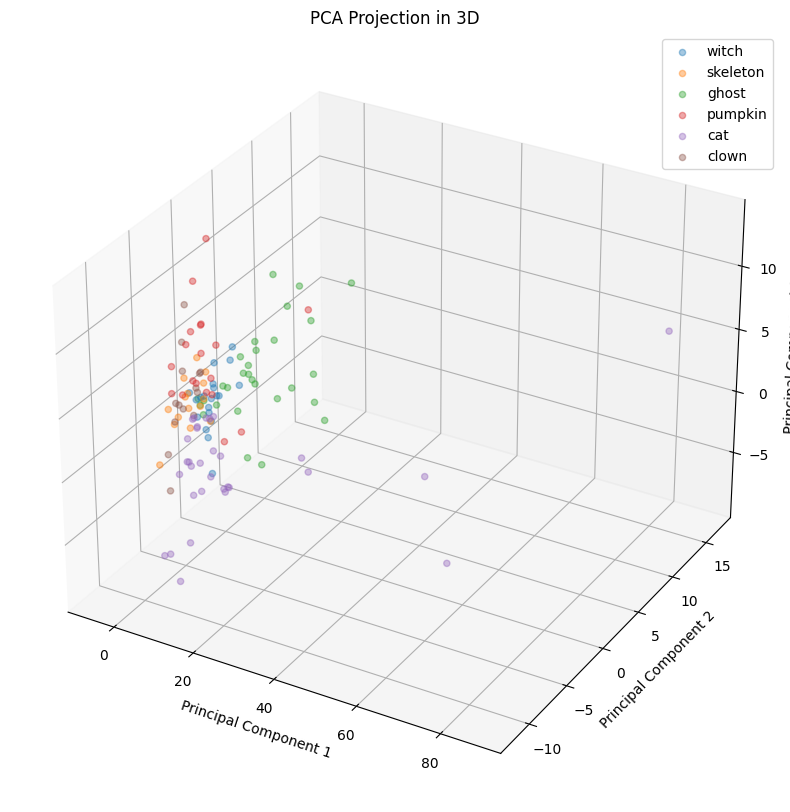

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model, Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.model_selection import train_test_split


# Load the trained model from the h5 file
saved_model_path = '/content/drive/MyDrive/go_kylie.h5'
pretrained_model = load_model(saved_model_path)


new_directory_path = '/content/drive/MyDrive/training cnn/augmented_data'
categories = os.listdir(new_directory_path)

# Create lists to store file paths and categories
file_paths = []
categories_list = []

for category in categories:
    category_path = os.path.join(new_directory_path, category)

    # List all images in the category
    category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)]

    # Add file paths and corresponding category to the lists
    file_paths.extend(category_images)
    categories_list.extend([category] * len(category_images))

# Create a DataFrame from the lists
data = {'filename': file_paths, 'category': categories_list}
df = pd.DataFrame(data)


# Split the DataFrame into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2)

# Extract the output before the final dense layer
x = pretrained_model.layers[-3].output  # -3 is the Flatten layer

# Create a new model that outputs the features before the final dense layer
feature_extraction_model = Model(inputs=pretrained_model.input, outputs=x)


# Load and preprocess the image dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255
)


# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=128,
    color_mode="rgb",
    class_mode='categorical',
)


# Get features from the generator
sample_batch, sample_labels = next(train_generator)
train_features = feature_extraction_model.predict(sample_batch)

# Reshape features for PCA
n_train = train_features.shape[0]
X = train_features.reshape((n_train, -1))  # Flatten all dimensions after the first one

# Apply PCA
pca = PCA(n_components=3)  # Set the number of components to 3 for 3D plotting
pca_result = pca.fit_transform(X)

class_names = ['witch','skeleton','ghost','pumpkin','cat','clown']
class_names_sorted = sorted(class_names)

# Scatter plot in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, class_name in enumerate(class_names):
    class_indices = np.where(sample_labels[:, i] == 1)[0]  # Get indices for the current class
    ax.scatter(
        pca_result[class_indices, 0],
        pca_result[class_indices, 1],
        pca_result[class_indices, 2],
        label=class_name,
        alpha=0.4
    )

ax.legend()
ax.set_title("PCA Projection in 3D")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.show()


# Testing the model on Etsy images

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model from the h5 file
saved_model_path = '/content/drive/MyDrive/Methodology/go_kylie.h5'
model = load_model(saved_model_path)

# Path to the folder containing the images
folder_path = '/content/drive/MyDrive/Methodology/singlefolder'


# Define a dictionary to map class indices to class names
class_names = {0: 'cat', 1: 'clown', 2: 'ghost', 3: 'pumpkin', 4: 'skeleton', 5: 'witch'}

# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Image', 'Predicted_Class'])

# Loop through each image in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Ensure the file is an image
        # Construct the full path to the image file
        img_path = os.path.join(folder_path, filename)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch
        img_array /= 255.0  # Preprocess the image

        # Make predictions
        predictions = model.predict(img_array)

        # Get the predicted class index
        predicted_class_index = np.argmax(predictions[0])

        # Map the class index to the class name
        predicted_class_name = class_names[predicted_class_index]

        # Append to the DataFrame
        df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)

# Display the final DataFrame
print("\nFinal DataFrame:")
print(df)

1/1 [==============================] - 3s 3s/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 71ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 131ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 78ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 129ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 110ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 61ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 22ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 162ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 58ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filenam

1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 17ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)
<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


1/1 [==============================] - 0s 23ms/step

Final DataFrame:
                                                Image Predicted_Class
0      Halloween costume cosplay Cleopatra danc_7.jpg           witch
1      Gothic All Over Cherry Skulls Bow Skull _8.jpg           witch
2                           Princess tutu dress_5.jpg           clown
3      Black With White Skele Hand Print Full F_1.jpg        skeleton
4       Skeleton Warm Gloves  Half Finger Glove_3.jpg        skeleton
...                                               ...             ...
1013  Adorable costume de bébé Pikachu Tenue _6.jpg           witch
1014    Halloween pumpkin felt mask kids and ad_5.jpg         pumpkin
1015     Princess girl costume marquise costume_1.jpg           clown
1016    Turkish Organic Cotton Women Long Dress_4.jpg             cat
1017    Vintage paper dress vintage corset dres_7.jpg        skeleton

[1018 rows x 2 columns]


<ipython-input-3-6a648e3ea37b>:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Image': filename, 'Predicted_Class': predicted_class_name}, ignore_index=True)


In [ ]:
df.head()

,Image,Predicted_Class
0,Halloween costume cosplay Cleopatra danc_7.jpg,witch
1,Gothic All Over Cherry Skulls Bow Skull _8.jpg,witch
2,Princess tutu dress_5.jpg,clown
3,Black With White Skele Hand Print Full F_1.jpg,skeleton
4,Skeleton Warm Gloves Half Finger Glove_3.jpg,skeleton


In [ ]:
df_feautures=pd.read_excel('/content/drive/MyDrive/Methodology/outputwithtags.xlsx')
df_feautures.head()

,Description,Price,Review_Number,File_Name,Product type,Price Range,Image_File,Manual classification
0,Halloween Croc Charms Clog Charm Shoe Pin Badg...,1.32,381,halloween_shoes_0-20_clean.txt,shoes,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
1,Etsy’s Pick Sage Vellum jacket 5x7 weddi...,1.33,26,halloween_jacket_0-20_clean.txt,jacket,0-20,NaN,NaN
2,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_shirt_0-20_clean.txt,shirt,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
3,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_sweater_0-20_clean.txt,sweater,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
4,"Boobiejuice SVG, Halloween Onesie® SVG, New Ba...",2.20,926,halloween_onesie_0-20_clean.txt,onesie,0-20,NaN,NaN


In [ ]:
df_feautures = df_feautures.dropna(subset=['Image_File'])
df_feautures = df_feautures.reset_index(drop=True)
df_feautures.head()

,Description,Price,Review_Number,File_Name,Product type,Price Range,Image_File,Manual classification
0,Halloween Croc Charms Clog Charm Shoe Pin Badg...,1.32,381,halloween_shoes_0-20_clean.txt,shoes,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
1,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_shirt_0-20_clean.txt,shirt,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
2,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_sweater_0-20_clean.txt,sweater,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN
3,"Wicked Cute SVG PNG PDF, Kids Halloween Svg, H...",2.40,195,halloween_onesie_0-20_clean.txt,onesie,0-20,C:\Users\57300\OneDrive - Universidad Externad...,ghost
4,"Jack Skellington Bow Tie SVG, Halloween Bow Ti...",2.44,913,halloween_tie_0-20_clean.txt,tie,0-20,C:\Users\57300\OneDrive - Universidad Externad...,NaN


In [ ]:
df_feautures['Image_File'][56]

'C:\\Users\\57300\\OneDrive - Universidad Externado de Colombia\\Desktop\\M2\\Machine learning & Statistical Learning\\soups\\images\\halloween_jacket_0-20\\Handmade Halloween earring in polymer cl_3.jpg'

In [ ]:
def keep_last_45_chars(original_string):
    result_string = original_string[-47:]
    return result_string


# Apply the eliminate function to the 'Path' column
df_feautures['Image_File'] = df_feautures['Image_File'].apply(keep_last_45_chars)

In [ ]:
def process_path(path):
    if '\\' in path:
        return path.split('\\')[-1]  # Take everything after the last backslash
    else:
        return path

# Apply the function to the 'Path' column
df_feautures['Image_File'] = df_feautures['Image_File'].apply(process_path)

In [ ]:
df_feautures['Image_File'][123]

'Jason Voorhees Hoodie Friday The 13Th H_2.jpg'

In [ ]:
len(df_feautures)

258

In [ ]:
print(df_feautures['Image_File'])

0      Halloween Croc Charms Clog Charm Shoe Pi_7.jpg
1      CT184 Halloween 2 12 Images_Drawings_col_6.jpg
2      CT184 Halloween 2 12 Images_Drawings_col_6.jpg
3       Wicked Cute SVG PNG PDF Kids Halloween _8.jpg
4       Jack Skellington Bow Tie Brooch The Bew_2.jpg
                            ...                      
253    1 READY TO SHIP Articulated skull mask r_1.jpg
254      Red Cape in veil for men Event Festiva_2.jpg
255    Freddy Krueger inspired The New Nightmar_3.jpg
256     60s LEONARD Silk Jersey Dress Vintage P_2.jpg
257    Vintage 1930s 1940s Cropped Cossack Jack_1.jpg
Name: Image_File, Length: 258, dtype: object


In [ ]:
full_data = df_feautures.merge(df, left_on='Image_File', right_on='Image')
len(full_data)

257

In [ ]:
full_data.to_csv('df_with_predictions.csv', index=False)

# Predicting sales

To predict the sales we decided to web scrape from Etsy website some information about the products and the images, that we already classified thanks to the CNN previously displayed.

In this part of the notebook, we well use the random forrest for regression to predict sales, using as a proxy the number of comments for each product.

We expect the model to be able to predict, however the dataset is composed of a limited number of elements due to some limitation in the process of web scraping. For this reason we expect it to be reliable only to some extent. The model could be improved adding more information on the product and enlarging the dataset.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
import pandas as pd
import numpy as np

In [ ]:
file_path = '/content/drive/MyDrive/CNN/df_with_predictions.csv'


df = pd.read_csv(file_path)
df

,Description,Price,Review_Number,File_Name,Product type,Price Range,Image_File,Manual classification,Image,Predicted_Class
0,Halloween Croc Charms Clog Charm Shoe Pin Badg...,1.32,381,halloween_shoes_0-20_clean.txt,shoes,0-20,Halloween Croc Charms Clog Charm Shoe Pi_7.jpg,NaN,Halloween Croc Charms Clog Charm Shoe Pi_7.jpg,pumpkin
1,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_shirt_0-20_clean.txt,shirt,0-20,CT184 Halloween 2 12 Images_Drawings_col_6.jpg,NaN,CT184 Halloween 2 12 Images_Drawings_col_6.jpg,witch
2,CT184 Halloween 2 12 Images/Drawings/collages/...,1.95,974,halloween_sweater_0-20_clean.txt,sweater,0-20,CT184 Halloween 2 12 Images_Drawings_col_6.jpg,NaN,CT184 Halloween 2 12 Images_Drawings_col_6.jpg,witch
3,"Wicked Cute SVG PNG PDF, Kids Halloween Svg, H...",2.40,195,halloween_onesie_0-20_clean.txt,onesie,0-20,Wicked Cute SVG PNG PDF Kids Halloween _8.jpg,ghost,Wicked Cute SVG PNG PDF Kids Halloween _8.jpg,ghost
4,"Jack Skellington Bow Tie SVG, Halloween Bow Ti...",2.44,913,halloween_tie_0-20_clean.txt,tie,0-20,Jack Skellington Bow Tie Brooch The Bew_2.jpg,NaN,Jack Skellington Bow Tie Brooch The Bew_2.jpg,skeleton
...,...,...,...,...,...,...,...,...,...,...
252,1 READY TO SHIP Articulated skull mask reprodu...,495.32,233,halloween_mask_100+_clean.txt,mask,100+,1 READY TO SHIP Articulated skull mask r_1.jpg,skeleton,1 READY TO SHIP Articulated skull mask r_1.jpg,ghost
253,"Red Cape in veil for men, Event, Festival, Sta...",508.02,372,halloween_cape_100+_clean.txt,cape,100+,Red Cape in veil for men Event Festiva_2.jpg,NaN,Red Cape in veil for men Event Festiva_2.jpg,skeleton
254,Freddy Krueger inspired The New Nightmare Bone...,658.12,301,halloween_gloves_100+_clean.txt,gloves,100+,Freddy Krueger inspired The New Nightmar_3.jpg,skeleton,Freddy Krueger inspired The New Nightmar_3.jpg,witch
255,"60s LEONARD Silk Jersey Dress, Vintage Paisley...",692.76,663,halloween_dress_100+_clean.txt,dress,100+,60s LEONARD Silk Jersey Dress Vintage P_2.jpg,NaN,60s LEONARD Silk Jersey Dress Vintage P_2.jpg,cat


In [ ]:
encoded_df = pd.get_dummies(df, columns=['Product type', 'Predicted_Class'])
columns_to_drop = ['Description', 'File_Name', 'Image_File', 'Price Range', 'Manual classification', 'Image']
encoded_df = encoded_df.drop(columns=columns_to_drop)
df = encoded_df
df

,Price,Review_Number,Product type_cape,Product type_costume,Product type_dress,Product type_gloves,Product type_hat,Product type_hoodie,Product type_jacket,Product type_leggings,...,Product type_skirt,Product type_socks,Product type_sweater,Product type_tie,Predicted_Class_cat,Predicted_Class_clown,Predicted_Class_ghost,Predicted_Class_pumpkin,Predicted_Class_skeleton,Predicted_Class_witch
0,1.32,381,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.95,974,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.95,974,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,2.40,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2.44,913,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,495.32,233,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
253,508.02,372,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
254,658.12,301,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
255,692.76,663,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, perform hyperparameter tuning on the training set using RandomizedSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

# Create the base model to tune
rf = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to search for the best hyperparameters
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=kf, verbose=2, random_state=42, n_jobs=-1, scoring="neg_mean_squared_error")
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", rf_random.best_params_)

# Print the best negative root mean squared error
print("Best RMSE:", rf_random.best_score_)

# Predictions on the test set
predictions = rf_random.best_estimator_.predict(X_test)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best RMSE: -65628.17745037559


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2): {r2}')


Mean Absolute Error (MAE): 210.91553855882108
Mean Squared Error (MSE): 69550.58554484953
R-squared (R2): -0.09392872848365719


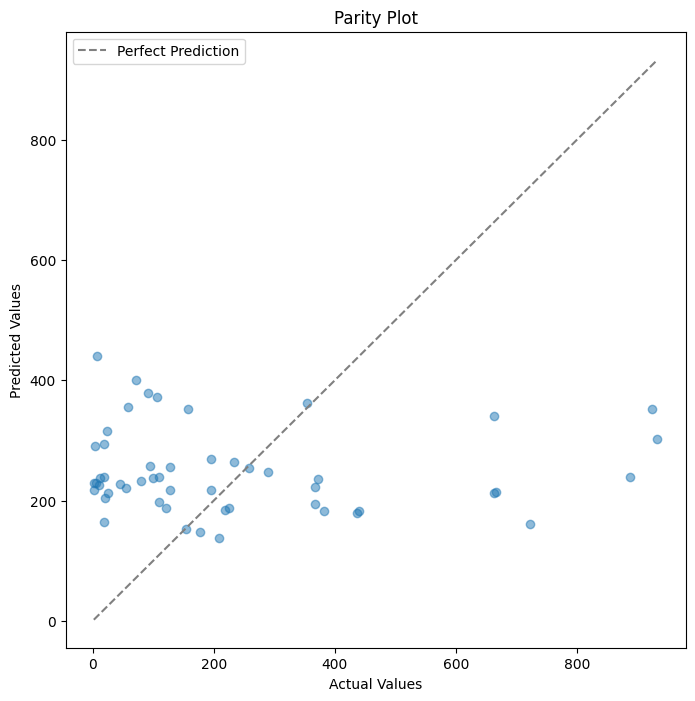

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parity plot
plt.figure(figsize=(8, 8))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='gray', label='Perfect Prediction')
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Parity Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


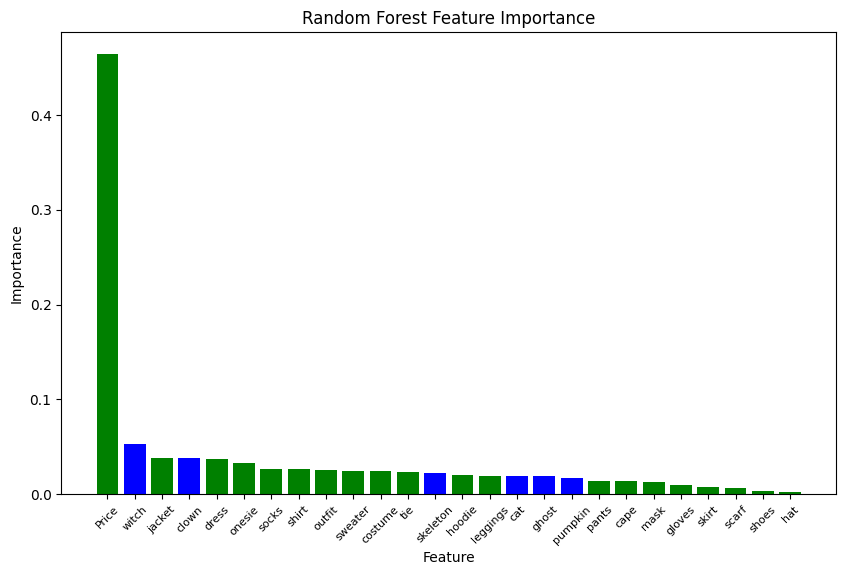

In [ ]:
best_model = rf_random.best_estimator_

# Get feature importances
feature_importances = best_model.feature_importances_

# Get feature names
feature_names = X.columns

# Modify labels to exclude "Predicted_class_" and "Product type"
modified_labels = [label.replace("Predicted_Class_", "").replace("Product type_", "") for label in feature_names]

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices], color=['blue' if feature_names[i].startswith("Predicted_Class_") else 'green' for i in indices], align='center')
plt.xticks(range(len(feature_importances)), [modified_labels[i] for i in indices], rotation=45, fontsize=8)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()


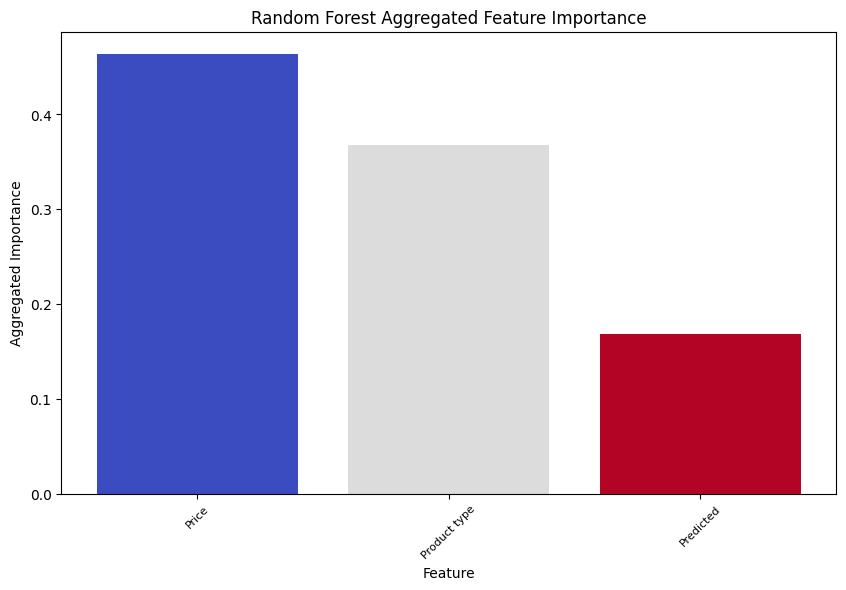

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

best_model = rf_random.best_estimator_

# Get feature importances
feature_importances = best_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame to store the aggregated importances
importance_df = pd.DataFrame(index=feature_names, data={'Importance': feature_importances})

# Aggregate importance scores for each original categorical variable
aggregated_importance_df = importance_df.groupby(lambda x: x.split('_')[0]).sum()

# Sort aggregated importance scores in descending order
aggregated_importance_df = aggregated_importance_df.sort_values(by='Importance', ascending=False)

# Assign a color to each feature using a different colormap (plasma in this case)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(aggregated_importance_df)))

# Plot the aggregated feature importances with different colors
plt.figure(figsize=(10, 6))
plt.bar(range(len(aggregated_importance_df)), aggregated_importance_df['Importance'], color=colors, align='center')
plt.xticks(range(len(aggregated_importance_df)), aggregated_importance_df.index, rotation=45, fontsize=8)
plt.xlabel('Feature')
plt.ylabel('Aggregated Importance')
plt.title('Random Forest Aggregated Feature Importance')
plt.show()
